2024-12-05 19:21:41.149461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 19:21:41.166433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 19:21:41.171730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 19:21:41.184401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/abarovic/anaconda3/envs/laney

Training set size: 40875
Validation set size: 10218
Test set size: 17031


/home/abarovic/anaconda3/envs/laney_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/abarovic/anaconda3/envs/laney_env/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 10
  Batch    50  of  1,278.
  Batch   100  of  1,278.
  Batch   150  of  1,278.
  Batch   200  of  1,278.
  Batch   250  of  1,278.
  Batch   300  of  1,278.
  Batch   350  of  1,278.
  Batch   400  of  1,278.
  Batch   450  of  1,278.
  Batch   500  of  1,278.
  Batch   550  of  1,278.
  Batch   600  of  1,278.
  Batch   650  of  1,278.
  Batch   700  of  1,278.
  Batch   750  of  1,278.
  Batch   800  of  1,278.
  Batch   850  of  1,278.
  Batch   900  of  1,278.
  Batch   950  of  1,278.
  Batch 1,000  of  1,278.
  Batch 1,050  of  1,278.
  Batch 1,100  of  1,278.
  Batch 1,150  of  1,278.
  Batch 1,200  of  1,278.
  Batch 1,250  of  1,278.

Evaluating...
  Batch    50  of    320.
  Batch   100  of    320.
  Batch   150  of    320.
  Batch   200  of    320.
  Batch   250  of    320.
  Batch   300  of    320.

Training Loss: 0.692
Validation Loss: 0.691

 Epoch 2 / 10
  Batch    50  of  1,278.
  Batch   100  of  1,278.
  Batch   150  of  1,278.
  Batch   200  of  1,278.


/tmp/ipykernel_3389131/2874680903.py:314: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


tensor([0.6069, 2.8389], device='cuda:1')

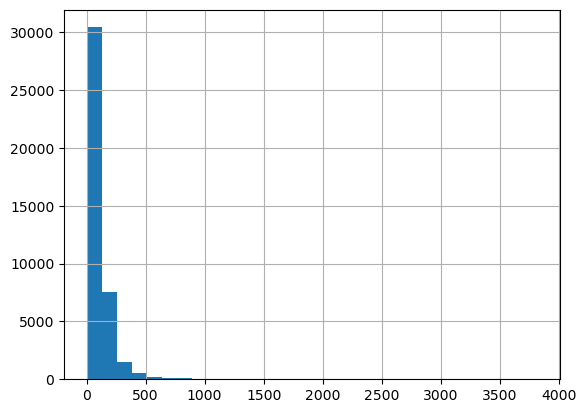

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
import torch.nn as nn
import time


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForMaskedLM
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
# in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

csv_file = '/home/abarovic/laneyREUTest/eclipse_platform.csv'
full_df = pd.read_csv(csv_file)

full_df.fillna(0, inplace=True)
length = len(full_df)
split_index = int(.8 * length)
df = full_df.iloc[:split_index]  # df=training set
# creating freeform textual data column
df['full_text_data'] = df['Description'] + df['Title']
df['full_text_data'] = df['full_text_data'].fillna('')

def is_duplicate(val):
    return 1 if val != 0.0 else 0

df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))
df.head()

X = df['full_text_data']  # Input features
y = df['isDuplicate']       # Target variable

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Use GPU 1
device = torch.device("cuda:1")

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

# split train dataset into train, validation and test sets
test_text, temp_text, test_labels, temp_labels = train_test_split(
    df['full_text_data'], df['isDuplicate'], random_state=42, test_size=0.75, stratify=df['isDuplicate']
)

val_text, train_text, val_labels, train_labels = train_test_split(
    temp_text, temp_labels, random_state=42, test_size=0.8, stratify=temp_labels
)

# Verify splits
print(f"Training set size: {len(train_text)}")
print(f"Validation set size: {len(val_text)}")
print(f"Test set size: {len(test_text)}")

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased').to(device)  # Move BERT to GPU 1

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins=30)

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=25,
    pad_to_max_length=True,
    truncation=True
)

# convert lists to tensors and move tensors to GPU 1
train_seq = torch.tensor(tokens_train['input_ids']).to(device)
train_mask = torch.tensor(tokens_train['attention_mask']).to(device)
train_y = torch.tensor(train_labels.tolist()).to(device)

val_seq = torch.tensor(tokens_val['input_ids']).to(device)
val_mask = torch.tensor(tokens_val['attention_mask']).to(device)
val_y = torch.tensor(val_labels.tolist()).to(device)

test_seq = torch.tensor(tokens_test['input_ids']).to(device)
test_mask = torch.tensor(tokens_test['attention_mask']).to(device)
test_y = torch.tensor(test_labels.tolist()).to(device)

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
train_seq.detach()
train_mask.detach()
train_y.detach()
#train_data.detach()
#train_sampler.detach()

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
val_seq.detach()
val_mask.detach()
val_y.detach()
#val_data.detach()
#val_sampler.detach()

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = BERT_Arch(bert).to(device)  # Move model to GPU 1
optimizer = AdamW(model.parameters(), lr=1e-5)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Move weights to GPU 1
cross_entropy = nn.NLLLoss(weight=weights)

epochs = 10

# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds=preds.detach().cpu().numpy()
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time()
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            #preds = preds.detach().cpu().numpy()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    torch.cuda.empty_cache()  # After each batch or epoch

torch.cuda.empty_cache()  # After each batch or epoch
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Get predictions for test data
# Get predictions for test data
#t.detach()
weights.detach()

In [2]:
model = model.cpu()  # Move the model to the CPU
test_y = test_y.cpu().numpy()

with torch.no_grad():
    test_seq_cpu = test_seq.detach().cpu()
    test_mask_cpu = test_mask.detach().cpu()
    preds = model(test_seq_cpu, test_mask_cpu)  # Perform computation on CPU
    preds = preds.detach().numpy()  # Convert to NumPy


# Convert predictions to class labels
predicted_classes = np.argmax(preds, axis=1)

# Generate classification report
report = classification_report(test_y, predicted_classes)
print(report)


              precision    recall  f1-score   support

           0       0.85      0.70      0.77     14031
           1       0.23      0.42      0.30      3000

    accuracy                           0.65     17031
   macro avg       0.54      0.56      0.53     17031
weighted avg       0.74      0.65      0.68     17031

